# AI DENTAL CARRY DETECTION MODEL WITH MOBILENET V2

In [7]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

# Load data
def load_data(data_dir):
    images, labels = [], []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for file in os.listdir(category_path):
                if os.path.splitext(file)[-1].lower() in valid_extensions:
                    img_path = os.path.join(category_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (224, 224))  # Resize to match MobileNetV2 expected input size
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)

# Dataset path
cropped_data_dir = '/Users/guhan.akilan/Downloads/Cnn Dental Carries'  # Adjust path
X, y = load_data(cropped_data_dir)

# Preprocess data
X = X.reshape(-1, 224, 224, 1)  # Add channel dimension for grayscale
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3 channels
X = preprocess_input(X)  # Normalize pixel values for MobileNetV2
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Class Weights for Imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Freeze fewer layers
for layer in base_model.layers[:80]:  # Freeze fewer layers
    layer.trainable = False

# Add custom layers
input_layer = Input(shape=(224, 224, 3))
x = base_model(input_layer, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Removed L2 regularization
x = Dropout(0.4)(x)  # Reduced Dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=1e-4),  # Moderate learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback for learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,  # Train for the full number of epochs
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[reduce_lr]  # No early stopping
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Save predictions for metrics and visualizations
np.savez('metrics_data.npz', y_test=y_test, y_pred=model.predict(X_test), label_encoder=label_encoder)

Epoch 1/50


/Users/guhan.akilan/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2766 - loss: 2.7956 - val_accuracy: 0.3979 - val_loss: 1.3255 - learning_rate: 1.0000e-04
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3300 - loss: 1.4721 - val_accuracy: 0.3875 - val_loss: 1.3198 - learning_rate: 1.0000e-04
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3895 - loss: 1.3450 - val_accuracy: 0.4671 - val_loss: 1.3694 - learning_rate: 1.0000e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4225 - loss: 1.2619 - val_accuracy: 0.4844 - val_loss: 1.2325 - learning_rate: 1.0000e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4620 - loss: 1.2251 - val_accuracy: 0.5156 - val_loss: 1.2741 - learning_rate: 1.0000e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4794 - loss: 1.1534 - val_accuracy: 0.4533 - val_loss: 1.9779 - learning_rate: 1.0000e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5154 - loss: 1.1631 - v

# Accuracy,Loss Trends and Confusion Matrix:

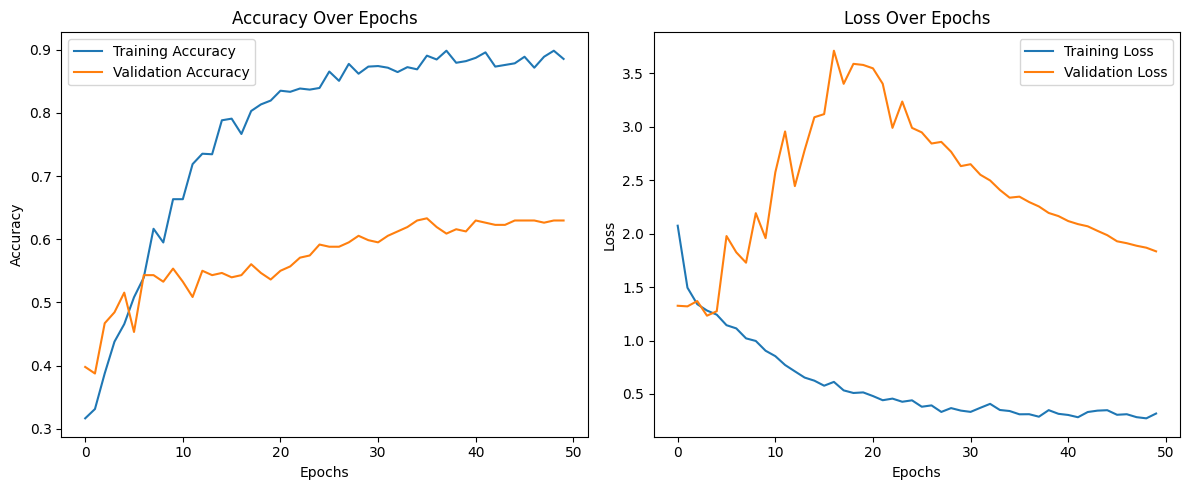

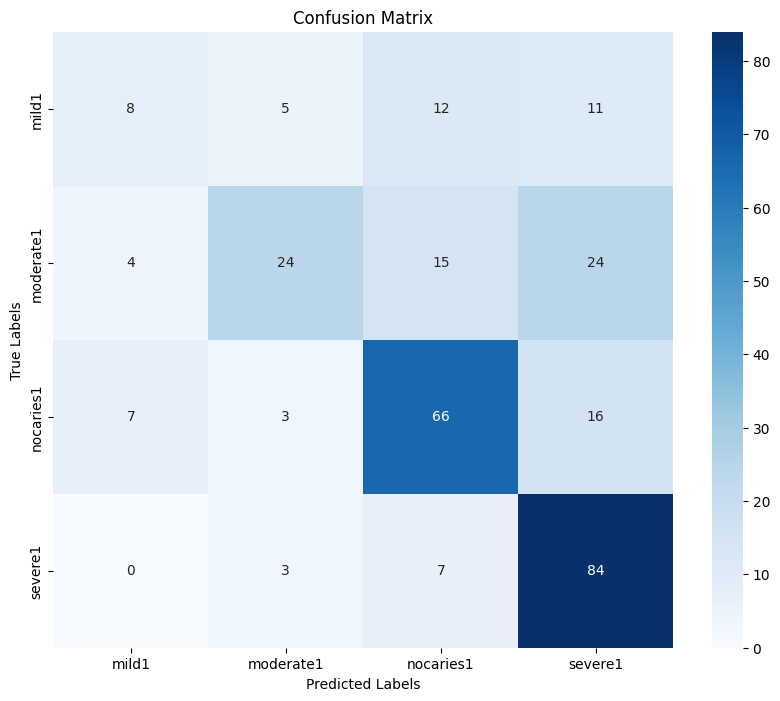

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmap visualization
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load saved data
data = np.load('metrics_data.npz', allow_pickle=True)
y_test = data['y_test']
y_pred = data['y_pred']
label_encoder = data['label_encoder'].item()

# 1. Plot Accuracy and Loss Trends
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Confusion Matrix
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 3. Additional Visualization (if required)
# Add any further metrics or visualizations as needed

# Metrics for accuracy, sensitivity, specificity, PPV, and NPV

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load saved data
data = np.load('metrics_data.npz', allow_pickle=True)
y_test = data['y_test']
y_pred = data['y_pred']
label_encoder = data['label_encoder'].item()

# Convert predictions and true labels to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Function to compute metrics
def compute_metrics(conf_matrix, label_idx):
    TP = conf_matrix[label_idx, label_idx]
    FN = conf_matrix[label_idx, :].sum() - TP
    FP = conf_matrix[:, label_idx].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    accuracy = (TP + TN) / conf_matrix.sum()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0

    return accuracy, sensitivity, specificity, ppv, npv

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Compute metrics for each class
results = []
for idx, class_name in enumerate(label_encoder.classes_):
    accuracy, sensitivity, specificity, ppv, npv = compute_metrics(conf_matrix, idx)
    results.append([class_name, accuracy, sensitivity, specificity, ppv, npv])

# Convert results to a DataFrame
metrics_df = pd.DataFrame(results, columns=["Class", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV"])

# Display the metrics table
print(metrics_df)

       Class  Accuracy  Sensitivity  Specificity       PPV       NPV
0      mild1  0.865052     0.222222     0.956522  0.421053  0.896296
1  moderate1  0.813149     0.358209     0.950450  0.685714  0.830709
2  nocaries1  0.792388     0.717391     0.827411  0.660000  0.862434
3    severe1  0.788927     0.893617     0.738462  0.622222  0.935065


# ROC Curve.

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step


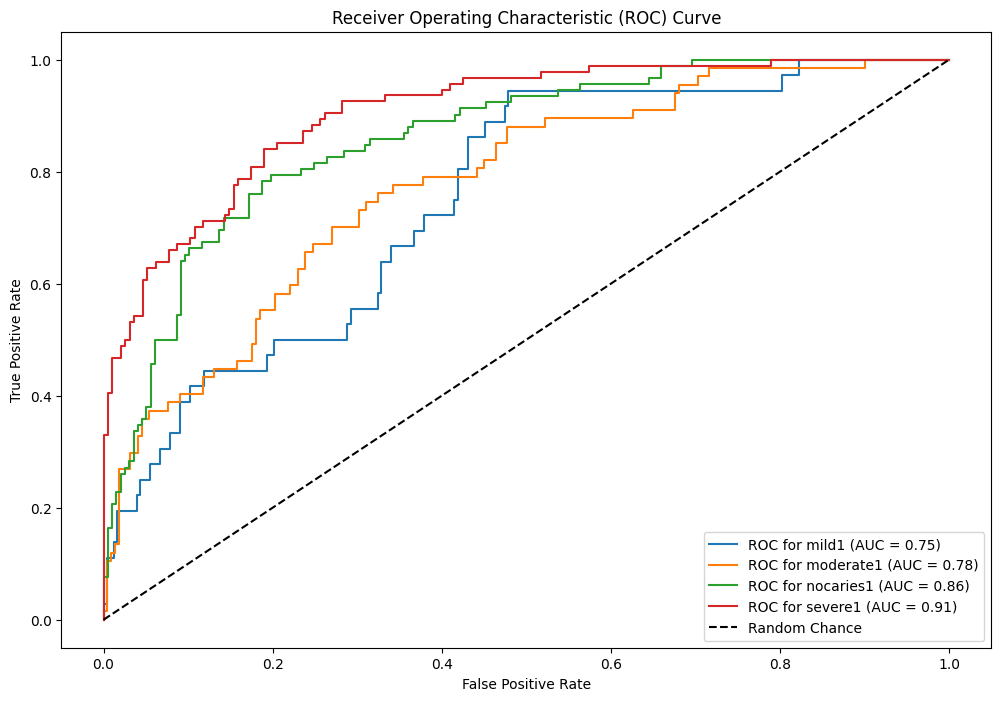

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC curves
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(y_categorical.shape[1]))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], model.predict(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC for {class_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve.

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 591ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 553ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 573ms/step


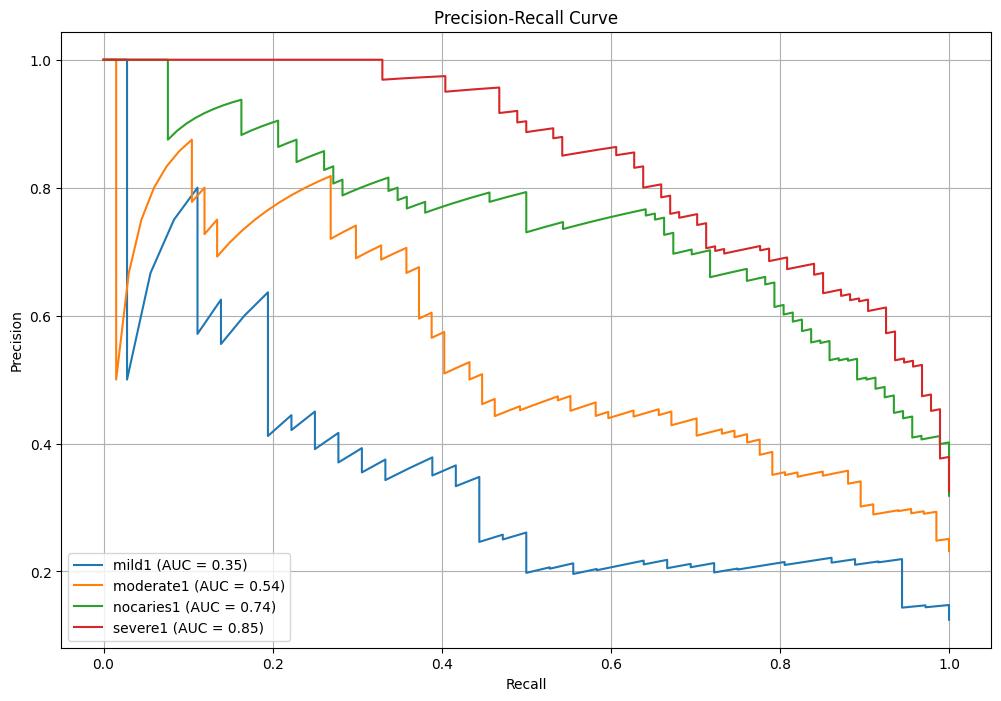

In [14]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], model.predict(X_test)[:, i])
    pr_auc = auc(recall, precision)  # Area under the precision-recall curve
    plt.plot(recall, precision, label=f'{class_name} (AUC = {pr_auc:.2f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Random Sampling of dental carries (cropped):

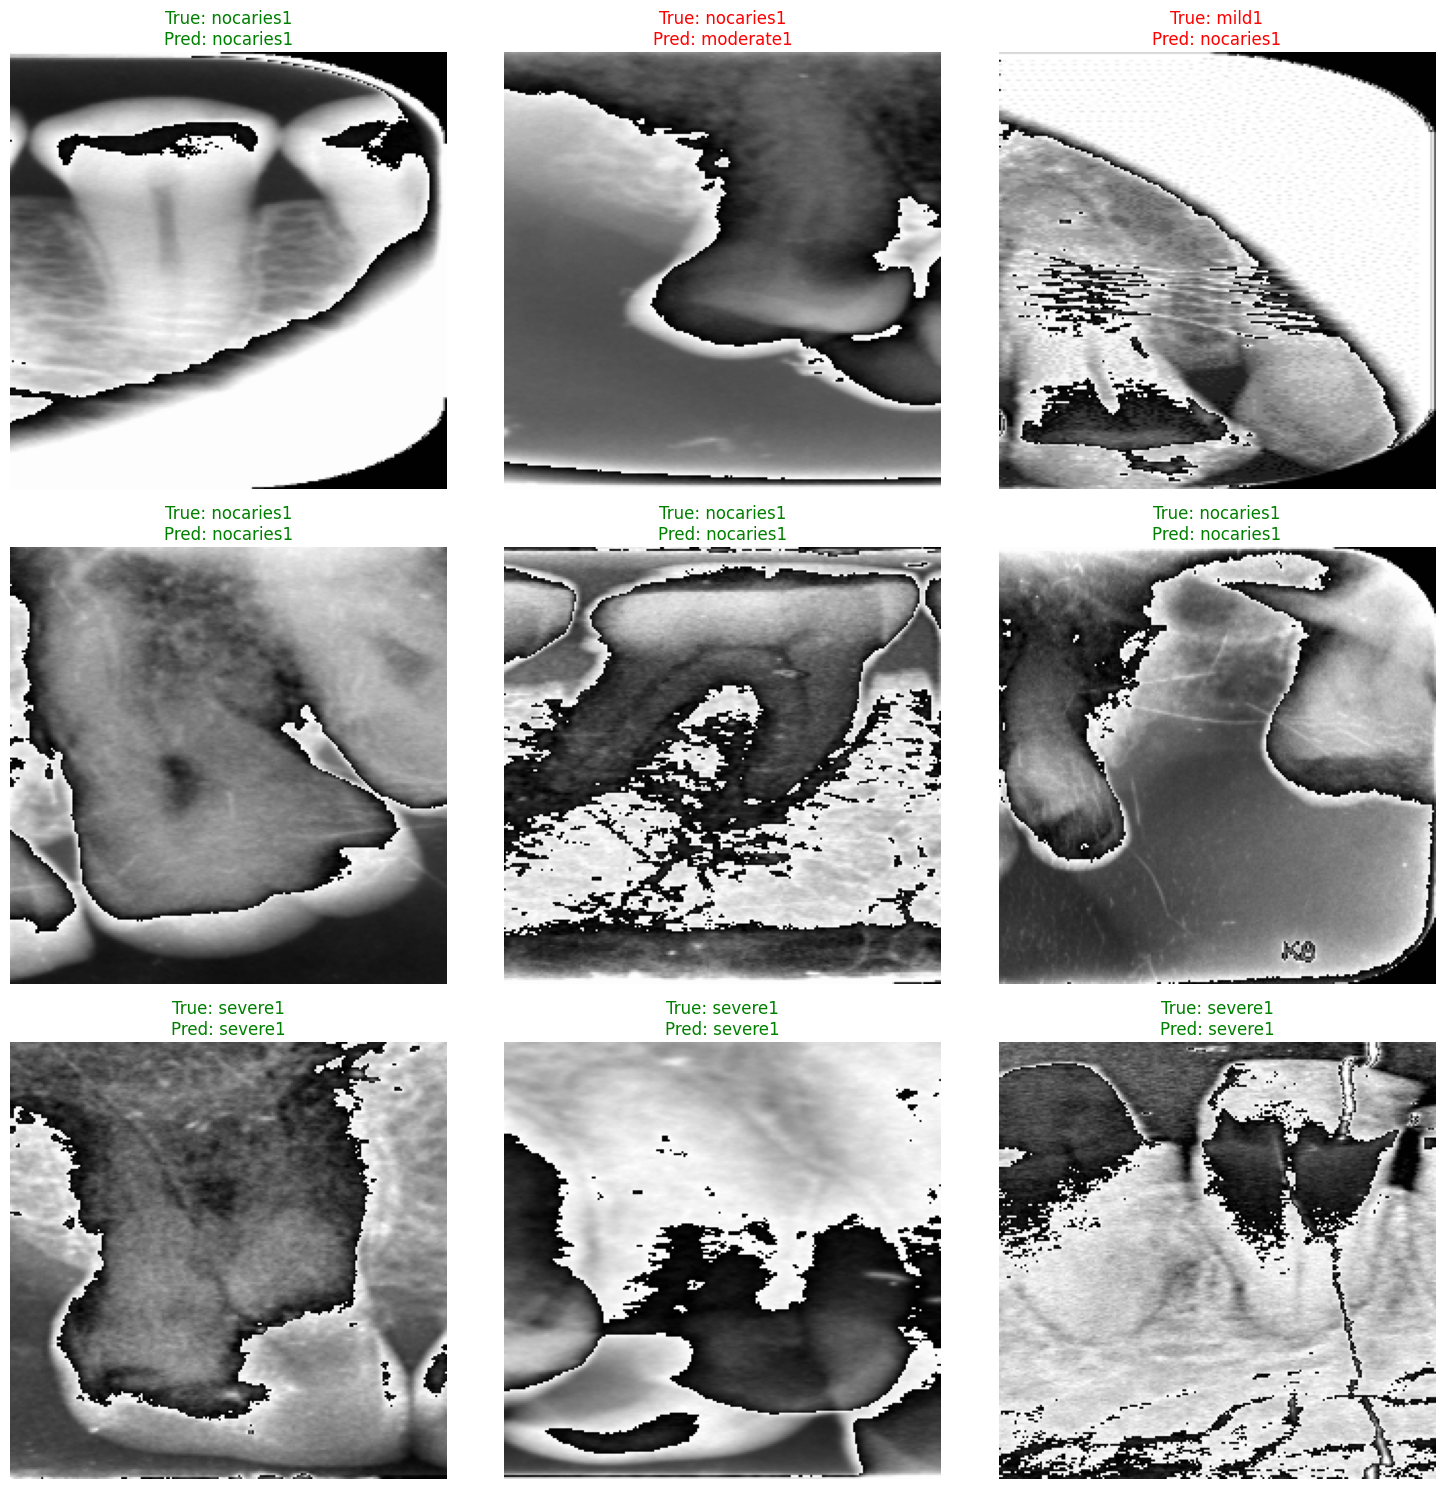

In [16]:
import random

def plot_real_sample_predictions(X, y_true, y_pred, label_encoder, num_samples=9):
    """
    Visualizes real dataset images with true and predicted labels.
    """
    plt.figure(figsize=(15, 15))
    indices = random.sample(range(len(X)), num_samples)  # Randomly select samples

    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        img = X[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization
        plt.imshow(img.astype('uint8'))
        
        # Decode labels
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        # Title with True and Predicted Labels
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ensure X_test contains the original images for better visualization
X_test_images = X_test * 255  # Rescale to original image range (0-255)
X_test_images = X_test_images.astype('uint8')

# Call the function to visualize predictions
plot_real_sample_predictions(X_test_images, y_true_classes, y_pred_classes, label_encoder)

# Sample predictions saved in a folder

In [17]:
import os

def save_all_predictions(X, y_true, y_pred, label_encoder, save_dir):
    """
    Saves images with true and predicted labels overlayed for all samples in the test set.
    
    Args:
    X (numpy array): Test images (scaled to 0-255 if necessary).
    y_true (list): True class labels (indices).
    y_pred (list): Predicted class labels (indices).
    label_encoder (LabelEncoder): Encoder for decoding class labels.
    save_dir (str): Directory to save the output images.
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    for idx in range(len(X)):
        # Prepare the image
        img = X[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization
        img = img.astype('uint8')  # Convert to uint8
        
        # Decode labels
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        # Overlay the true and predicted labels
        overlay_text = f"True: {true_label} | Pred: {pred_label}"
        color = (0, 255, 0) if true_label == pred_label else (255, 0, 0)  # Green for correct, Red for incorrect
        img = cv2.putText(img, overlay_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
        
        # Save the image
        save_path = os.path.join(save_dir, f"sample_{idx + 1}.png")
        cv2.imwrite(save_path, img)

    print(f"All predictions saved in: {save_dir}")

# Rescale test images for visualization
X_test_images = (X_test * 255).astype('uint8')  # Rescale to original range (0-255)

# Define save directory
save_directory = "predicted_samples"

# Save all predictions
save_all_predictions(X_test_images, y_true_classes, y_pred_classes, label_encoder, save_directory)

All predictions saved in: predicted_samples


#  AUC, Sensitivity, and Specificity with Cross-Tabulation

           Sensitivity  Specificity  Accuracy
mild1         0.222222     0.956522  0.865052
moderate1     0.358209     0.950450  0.813149
nocaries1     0.717391     0.827411  0.792388
severe1       0.893617     0.738462  0.788927


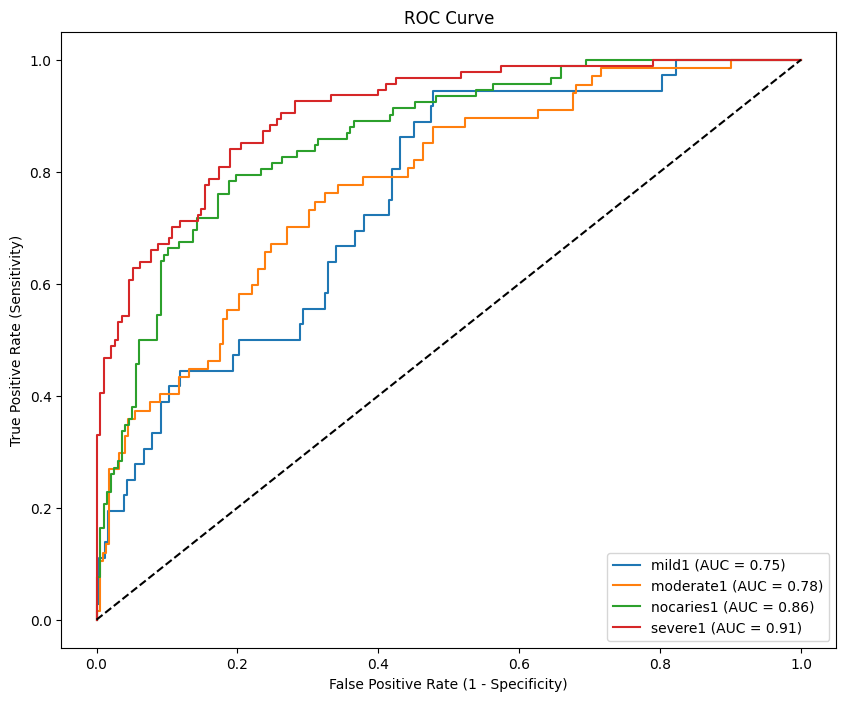

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Helper to calculate sensitivity and specificity
def compute_metrics(y_true, y_pred, label_encoder):
    """
    Compute Sensitivity, Specificity, and Cross-Tabulated Accuracy.
    
    Args:
    - y_true: Ground truth class indices.
    - y_pred: Predicted class indices.
    - label_encoder: LabelEncoder to decode class labels.
    
    Returns:
    - metrics_dict: Dictionary containing Sensitivity, Specificity, and Accuracy for each class.
    """
    metrics_dict = {}
    for class_idx, class_name in enumerate(label_encoder.classes_):
        # Binary classification for the current class
        binary_y_true = (y_true == class_idx).astype(int)
        binary_y_pred = (y_pred == class_idx).astype(int)

        # Confusion Matrix for the current class
        tn, fp, fn, tp = confusion_matrix(binary_y_true, binary_y_pred).ravel()

        # Sensitivity and Specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics_dict[class_name] = {
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Accuracy": (tp + tn) / (tp + tn + fp + fn)
        }
    
    return metrics_dict

# Compute AUC for each class
def plot_roc_auc(y_test, y_pred, label_encoder):
    """
    Plot the ROC Curve and calculate AUC for each class.
    """
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# True and Predicted Labels
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute metrics
metrics = compute_metrics(y_true_classes, y_pred_classes, label_encoder)

# Display Metrics
import pandas as pd
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Plot ROC Curve
plot_roc_auc(y_test, y_pred, label_encoder)

# Automated Dataset Evaluation and Prediction Scoring Framework for Model Performance Analysis

In [10]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define scoring dictionary with correct labels
scoring = {"nocaries1": 0, "mild1": 1, "moderate1": 2, "severe1": 3}

# Load data
def load_data(data_dir):
    images, labels = [], []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for file in os.listdir(category_path):
                if os.path.splitext(file)[-1].lower() in valid_extensions:
                    img_path = os.path.join(category_path, file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (224, 224))  # Resize to required dimensions
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)

# Save data to Excel
def save_data_to_excel(X, y_true, y_pred, label_encoder, save_path, dataset_type="Test"):
    """
    Save dataset with true and predicted labels into an Excel file.
    """
    data = []
    for idx in range(len(X)):
        # Decode labels
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        
        # Save each row
        data.append({
            "Index": idx + 1,
            "Dataset Type": dataset_type,
            "True Label": true_label,
            "Predicted Label": pred_label,
            "True Score (Ideal)": scoring[true_label],
            "Predicted Score": scoring[pred_label]
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Save to Excel
    df.to_excel(save_path, index=False)
    print(f"Data saved to Excel file at: {save_path}")

# Dataset path
cropped_data_dir = '/Users/guhan.akilan/Downloads/Cnn Dental Carries'  # Replace with your dataset path
X, y = load_data(cropped_data_dir)

# Preprocess data
X = X.reshape(-1, 224, 224, 1)  # Add channel dimension for grayscale
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to 3 channels (RGB)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels into integers
y_categorical = to_categorical(y_encoded)   # Convert to one-hot encoding

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Dummy predictions for demonstration purposes
# Replace np.random.rand(...) with your actual model.predict() calls
y_train_classes = np.argmax(y_train, axis=1)
y_train_pred = np.argmax(np.random.rand(len(y_train), len(label_encoder.classes_)), axis=1)  # Replace with model.predict(X_train)
y_test_classes = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(np.random.rand(len(y_test), len(label_encoder.classes_)), axis=1)    # Replace with model.predict(X_test)

# Save training data to Excel
save_data_to_excel(X_train, y_train_classes, y_train_pred, label_encoder, "training_data.xlsx", dataset_type="Train")

# Save testing data to Excel
save_data_to_excel(X_test, y_test_classes, y_test_pred, label_encoder, "testing_data.xlsx", dataset_type="Test")

Data saved to Excel file at: training_data.xlsx
Data saved to Excel file at: testing_data.xlsx
